In [1]:
%matplotlib inline
import matplotlib


In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle

In [3]:
#load data
print ("loading data")
#iterate over directory and get all png images\n
imageset = np.empty((7704,64,64,3), dtype='float32')

#There are 7704 images in the dataset.
#214 folders. Each having 36 images.
rootdir = '/home/chsarath/kaushal_project/mug/models/3dw'
cnt = 0
total_cnt = 0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith('.png'):
            if cnt == 36:
                cnt = 0
                total_cnt += 1
            cnt += 1
            seq_number = int(filepath.split('-')[-1].split('.')[0])
            
            imageset[total_cnt*36 + seq_number] = misc.imread(filepath).astype(np.float32)
            
print ('loading done')

loading data
loading done


In [4]:
#this part is to visulize image
tmp = imageset[3]
print (tmp.shape)

total_images, W, H, C = imageset.shape
print (total_images)
training_examples = 170
test_examples = 36

(64, 64, 3)
7704


In [5]:
#First 170 folders. 170*36 = 6120 images would be used for training
# rest 44 folders would be used for testing

data_ = np.zeros((21400,W,H,C))
labels_ = np.zeros((21400,W,H,C))
pose = np.zeros((21400,8,8,36))

for cnt in range(214):
    tmp_data = np.zeros((1296,W,H,C))
    tmp_labels = np.zeros((1296,W,H,C))
    tmp_pose = np.zeros((1296,8,8,36))
    for i in range(36):
        for j in range(36):
            num = (j-i)%36
            pose_tmp = np.zeros(36)
            pose_tmp[num] = 1
            tmp_pose[i*36 + j] = np.broadcast_to(pose_tmp,(8,8,36))
            tmp_data[i*36 + j] = imageset[cnt*36 + i]
            tmp_labels[i*36 + j] = imageset[cnt *36 + j]         
    rand_nums = np.random.randint(0,1295,100)
    data_[cnt*100 : (cnt+1)*100] = tmp_data[rand_nums]
    labels_[cnt*100 : (cnt+1)*100] = tmp_labels[rand_nums]
    pose[cnt*100 : (cnt+1)*100] = tmp_pose[rand_nums]

data_, labels_, pose = shuffle(data_, labels_, pose, random_state=0)

data_train = data_[:17000]
data_test = data_[17000:]

train_labels = labels_[:17000]
test_labels = labels_[17000:]

pose_train = pose[:17000]
pose_test = pose[17000:]





[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


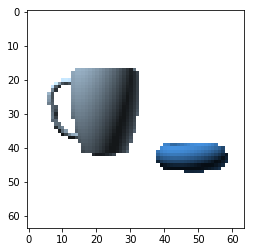

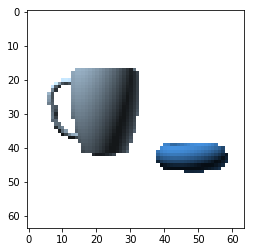

In [6]:

tmp = test_labels[13][...,::-1]
tmp1 = data_test[13][...,::-1]

print(pose[17000+ 13][0][0])
plt.imshow(tmp1/255)
plt.show()
plt.imshow(tmp/255)
plt.show()


In [7]:
#normalize data


data_train *= 2
data_train /= 255
data_train -= 1

data_test *= 2
data_test /= 255
data_test -= 1


train_labels *= 2
train_labels /= 255
train_labels -= 1

test_labels *= 2
test_labels /= 255
test_labels -= 1



In [8]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [9]:
#defination of my layers
'''
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b
'''
def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b
def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def deconv2d(input, kernel_size, stride, num_filter):
    filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
    # tf.constant([input.get_shape()[0], input.get_shape()[1]*2, input.get_shape()[1]*2, num_filter], tf.int32)
    input_dim = input.get_shape().as_list()
    batch_size = input_dim[0]
    w = input_dim[1]
    out_shape = tf.stack([batch_size, w*2, w*2, num_filter])    
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
    stride_shape = [1, stride, stride, 1]
    W = tf.get_variable('w', filter_shape, tf.float32, tf.contrib.layers.xavier_initializer())
    
    return tf.nn.conv2d_transpose(input, W, out_shape, stride_shape) + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b


def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

In [10]:

# Network Parameters

#Encoder
# input is 64 * 64 * 3 
# batch_size is 72


# tf Graph input (only pictures)

class AutoEncoder(object):
    
    def __init__(self):
        self.inputs_ = tf.placeholder(tf.float32, [None, 64, 64, 3])
        self.targets_ = tf.placeholder(tf.float32, [None, 64, 64, 3])
        self.pose_ = tf.placeholder(tf.float32, [None, 8, 8, 36])
        self.is_train = tf.placeholder(tf.bool)
        self.num_epoch = 100
        self.batch_size = 20
        self.num_training = 17000
        self._build_model()
        
    def _encoder_decoder(self):
        with tf.variable_scope('conv1'):
            _ = conv2d(self.inputs_, 3, 2, 16, 'conv1')
            #_ = batch_norm(_, self.is_train)
            _ = tf.nn.relu(_)
            _ = conv2d(_, 3, 2, 32, 'conv2')
            #_ = batch_norm(_, self.is_train)
            _ = tf.nn.relu(_)
            #_ = conv2d(_, 3, 2, 64, 'conv3')
            #_ = tf.nn.relu(_)
            _ = conv2d(_, 3, 2, 64, 'conv4')
            _ = tf.nn.relu(_)
            _ = tf.concat([_, self.pose_], 3)
            #_ = conv2d_transpose(_, 3, 2, 64, 'deconv0')
            #_ = tf.nn.relu(_)
            _ = conv2d_transpose(_, 3, 2, 32, 'deconv1')
            #_ = batch_norm(_, self.is_train)
            _ = tf.nn.relu(_)
            _ = conv2d_transpose(_, 3, 2, 16, 'deconv2')
            #_ = batch_norm(_, self.is_train)
            _ = tf.nn.relu(_)
            _ = conv2d_transpose(_, 3, 2, 3, 'deconv3')
            _ = tf.nn.tanh(_)
            return _

    def _loss(self, labels, logits):
        self.loss_op = tf.reduce_mean(abs(labels - logits))
    
    def _build_optimizer(self):
        global_step = tf.Variable(0,trainable=False)
        lr = tf.train.exponential_decay(5e-4, global_step, 1000, 0.96, staircase=True)
        optimizer = tf.train.AdamOptimizer(lr)
        self.train_op = optimizer.minimize(loss=self.loss_op)

    def _build_model(self):
        self.out = self._encoder_decoder()
        self._loss(self.out, self.targets_)
        self._build_optimizer()
        
    def train(self, sess, X_train, Y_train, pose):
        sess.run(tf.global_variables_initializer())
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for e in range(self.num_epoch):
            for ii in range(X_train.shape[0] // self.batch_size):
                batch = X_train[ii*self.batch_size : (ii+1)*self.batch_size]
                batch_labels = Y_train[ii*self.batch_size : (ii+1)*self.batch_size]
                pose_labels = pose[ii*self.batch_size : (ii+1)*self.batch_size]
                feed_dict = {self.inputs_: batch, self.targets_: batch_labels, self.pose_:pose_labels, self.is_train:True}
                fetches = [self.train_op, self.loss_op]
                _, loss = sess.run(fetches, feed_dict=feed_dict)
            print("Epoch: {}/{}...".format(e+1, self.num_epoch),
                "Training loss: {:.4f}".format(loss))
    
    def evaluate(self, sess, X_eval, Y_eval, pose_eval):
        out = np.zeros(Y_eval.shape)
        for ii in range(X_eval.shape[0] // self.batch_size):
            batch = X_eval[ii*self.batch_size : (ii+1)*self.batch_size]
            batch_labels = Y_eval[ii*self.batch_size : (ii+1)*self.batch_size]
            pose_labels = pose_eval[ii*self.batch_size : (ii+1)*self.batch_size]
            feed_dict = {self.inputs_: batch, self.targets_: batch_labels, self.pose_:pose_labels, self.is_train:False}
            fetches = [self.train_op, self.loss_op, self.out]
            _, loss, out[ii*self.batch_size : (ii+1)*self.batch_size] = sess.run(fetches, feed_dict=feed_dict)
            print ("loss: {:.4f}".format(loss))
        return out

In [11]:
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    #with tf.device('/device:gpu:0'):
    model = AutoEncoder()
    model.train(sess, data_train, train_labels, pose_train)
    output = model.evaluate(sess, data_test, test_labels, pose_test)
    saver = tf.train.Saver()
    model_path = saver.save(sess, "saved_models/encoder_pose.ckpt")
    print("Model saved in %s" % model_path)


-----  Start training  -----
Epoch: 1/100... Training loss: 0.3156
Epoch: 2/100... Training loss: 0.3030
Epoch: 3/100... Training loss: 0.2908
Epoch: 4/100... Training loss: 0.2827
Epoch: 5/100... Training loss: 0.2770
Epoch: 6/100... Training loss: 0.2754
Epoch: 7/100... Training loss: 0.2715
Epoch: 8/100... Training loss: 0.2646
Epoch: 9/100... Training loss: 0.2635
Epoch: 10/100... Training loss: 0.2597
Epoch: 11/100... Training loss: 0.2596
Epoch: 12/100... Training loss: 0.2588
Epoch: 13/100... Training loss: 0.2579
Epoch: 14/100... Training loss: 0.2564
Epoch: 15/100... Training loss: 0.2558
Epoch: 16/100... Training loss: 0.2537
Epoch: 17/100... Training loss: 0.2516
Epoch: 18/100... Training loss: 0.2510
Epoch: 19/100... Training loss: 0.2462
Epoch: 20/100... Training loss: 0.2469
Epoch: 21/100... Training loss: 0.2452
Epoch: 22/100... Training loss: 0.2419
Epoch: 23/100... Training loss: 0.2397
Epoch: 24/100... Training loss: 0.2395
Epoch: 25/100... Training loss: 0.2395
Epoch

In [13]:
other = np.array(output)

print (other.shape)

(4400, 64, 64, 3)


In [14]:

other += 1
other *=  255
other /= 2


(64, 64, 3)


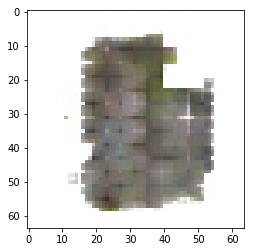

In [54]:

tmp = other[1240]
print (tmp.shape)
plt.imshow(tmp/255)
plt.show()

In [35]:

test_labels += 1
test_labels *=  255
test_labels /= 2




(64, 64, 3)


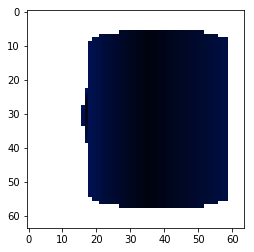

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [37]:
tmp = test_labels[3102]
print (tmp.shape)
plt.imshow(tmp/255)
plt.show()
print (pose_test[451][0][0])